In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 05/06/2021

    Code description :
    __________________
    Apply forward and adjoint operators to observe their effects.
 
"""
import matplotlib.pyplot as plt
import numpy as np

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),2),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from graphics import set_plot_params, subplot_axs, labels
from shepp_logan import phantom
set_plot_params() # Set the plot params

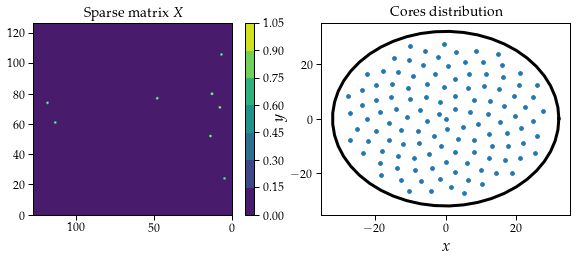

In [4]:
K = 8 # sparsity of matrix
N=128 # size of the image

"Create the sample space"
pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
X = np.zeros((N,N))
"Define the sparse object"
for i in range(K):
    X[pos_x[i], pos_y[i]] = (-1)**i
"The mean removing is currently off because the object is zero mean by construction"
# X -= np.mean(X) # Equivalent to removing the diagonal of interferometric matrix F[f]

"Fermat spiral"
Q = 120 # number of cores
# diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
diam_endo = N//2
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_sources[0,:], pos_sources[0,:]).astype(int)
Om_y = np.subtract.outer(pos_sources[1,:], pos_sources[1,:]).astype(int)

"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity(Om_x, Om_y)

"Plots"
fig = plt.figure(figsize=(8,4))
axs = subplot_axs(fig, 1,2)
im0 = axs[0].contourf(np.abs(X), cmap='viridis')
axs[0].invert_xaxis()
axs[0].set_title('Sparse matrix $X$')
fig.colorbar(im0, ax=axs[0])
theta = np.linspace(0,2*np.pi,50)
axs[1].plot(diam_endo/2*np.cos(theta), diam_endo/2*np.sin(theta), 'k', label='Borders')
cores = axs[1].scatter(pos_sources[0], pos_sources[1], marker='o', label='Sources', s = 15)
labels(axs[1], r'Cores distribution', '$x$', '$y$')

plt.show()

### Check $\boldsymbol{S}_{\Omega}^*(\boldsymbol{S}_{\Omega}(\cdot))$

In [5]:
Om_xtmp = np.array([[1,3,1],[1,3,2]])
Om_ytmp = np.array([[1,2,1],[2,3,1]])
mult_tmp = ind_multiplicity(Om_xtmp, Om_ytmp)
Ntmp=4
# Xtmp = np.ones((4,4))
Xtmp = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
tmp = S_Om(Xtmp, Om_xtmp, Om_ytmp, mult_mat=mult_tmp)
tmp2 = S_Om_star(tmp, Om_xtmp, Om_ytmp, (4,4), mult_mat=mult_tmp)

print('Matrix M')
print(Xtmp)
print('\n S_Om(M)')
print(tmp)
print('\n S_Om_star(S_Om(M))')
print(tmp2)

Matrix M
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

 S_Om(M)
[[ 4.24264069 12.          4.24264069]
 [10.         16.          7.        ]]

 S_Om_star(S_Om(M))
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  6.+0.j  7.+0.j  0.+0.j]
 [ 0.+0.j 10.+0.j  0.+0.j 12.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j 16.+0.j]]


True


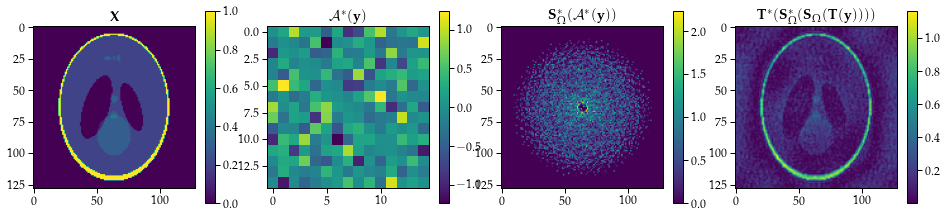


 1) We observe the image domain of S_Om in the second plot, which is hermitian and with constant diagonal as expected for the interferometric matrix.

 2) In the third plot, we observe the sampling performed by the LE in the Fourier domain.

 3) In the last plot, we observe the inverse Fourier transform of the object which has been sampled in Fourier.


In [9]:
Xt = phantom(N)
M=1500
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)
u = A(S_Om(T(Xt),Om_x,Om_y, mult_mat=multiplicities),a_ij)

test = A_star2(u, a_ij, diagless=True)
test2 = S_Om_star(test, Om_x, Om_y, (N,N), mult_mat=multiplicities)
test3 = T_star(S_Om_star(S_Om(T(Xt),Om_x,Om_y, mult_mat=multiplicities), Om_x, Om_y, (N,N), mult_mat=multiplicities))

print(is_hermitian(test))

"Plot"
fig = plt.figure(figsize=(13,4))
axs = subplot_axs(fig, 1,4)
im0 = axs[0].imshow(Xt, cmap='viridis')
im1 = axs[1].imshow(np.imag(test[:15,:15]), cmap='viridis')
im2 = axs[2].imshow(np.fft.fftshift(np.abs(test2)), cmap='viridis')
im3 = axs[3].imshow(np.abs(test3), cmap='viridis')
axs[0].set_title(r'$\mathbf{X}$')
axs[1].set_title(r'$\mathcal{A}^*(\mathbf{y})$')
axs[2].set_title(r'$\mathbf{S}_{\Omega}^*(\mathcal{A}^*(\mathbf{y}))$')
axs[3].set_title(r'$\mathbf{T}^*(\mathbf{S}_{\Omega}^*(\mathbf{S}_{\Omega}(\mathbf{T}(\mathbf{y}))))$')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
fig.colorbar(im3, ax=axs[3])
plt.show()

print('\n 1) We observe the image domain of S_Om in the second plot, which is hermitian and with constant diagonal as expected for the interferometric matrix.')
print('\n 2) In the third plot, we observe the sampling performed by the LE in the Fourier domain.')
print('\n 3) In the last plot, we observe the inverse Fourier transform of the object which has been sampled in Fourier.')

### Random sampling in Fourier domain

True


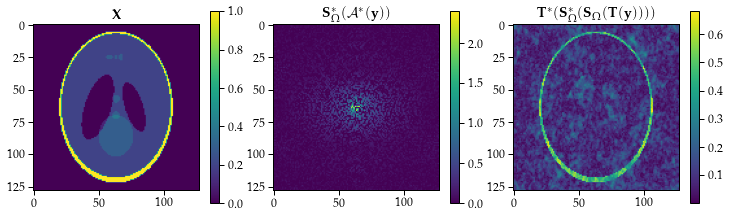

In [11]:
Xt = phantom(N)

Om_x_random = np.random.randint(N, size=(Q, Q) )
Om_y_random = np.random.randint(N, size=(Q, Q) )
multiplicities_random = ind_multiplicity(Om_x_random, Om_y_random)

u = S_Om(T(Xt),Om_x_random,Om_y_random, mult_mat=multiplicities_random)
test2 = S_Om_star(u, Om_x_random, Om_y_random, (N,N), mult_mat=multiplicities_random)
test3 = T_star(test2)

print(is_hermitian(test))

"Plot"
fig = plt.figure(figsize=(10,4))
axs = subplot_axs(fig, 1,3)
im0 = axs[0].imshow(Xt, cmap='viridis')
im1 = axs[1].imshow(np.fft.fftshift(np.abs(test2)), cmap='viridis')
im2 = axs[2].imshow(np.abs(test3), cmap='viridis')
axs[0].set_title(r'$\mathbf{X}$')
axs[1].set_title(r'$\mathbf{S}_{\Omega}^*(\mathcal{A}^*(\mathbf{y}))$')
axs[2].set_title(r'$\mathbf{T}^*(\mathbf{S}_{\Omega}^*(\mathbf{S}_{\Omega}(\mathbf{T}(\mathbf{y}))))$')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
plt.show()